# Introduction to Generative Modeling (Anime Faces : Run with Colab)

Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adversarial Networks or GANs, however, use neural networks for a very different purpose: Generative modeling

> Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset. - [Source](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

To get a sense of the power of generative models, just visit [thispersondoesnotexist.com](https://thispersondoesnotexist.com). Every time you reload the page, a new image of a person's face is generated on the fly. The results are pretty fascinating:

<img src="https://imgix.bustle.com/inverse/4b/17/8f/0e/cf91/4506/99c7/e6a491c5d4ac/these-people-are-not-real--they-were-produced-by-our-generator-that-allows-control-over-different-a.png" style="width:480px; margin-bottom:32px"/>

While there are many approaches used for generative modeling, a Generative Adversarial Network takes the following approach: 

<img src="https://i.imgur.com/6NMdO9u.png" style="width:420px; margin-bottom:32px"/>

There are two neural networks: a *Generator* and a *Discriminator*. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs. 

GANs however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization. In this tutorial, we'll train a GAN to generate images of anime characters' faces.

<img src="https://i.imgur.com/NaKtJs0.png" width="360" style="margin-bottom:32px"/>


We'll use the [Anime Face Dataset](https://github.com/Mckinsey666/Anime-Face-Dataset), which consists of over 63,000 cropped anime faces. Note that generative modeling is an unsupervised learning task, so the images do not have any labels. Most of the code in this tutorial is based [on this notebook](https://www.kaggle.com/splcher/starter-anime-face-dataset). 

In [ ]:
# Uncomment and run the appropriate command for your operating system, if required
# No installation is reqiured on Google Colab / Kaggle notebooks

# Linux / Binder / Windows (No GPU)
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Linux / Windows (GPU)
# pip install numpy matplotlib torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
 
# MacOS (NO GPU)
# !pip install numpy matplotlib torch torchvision torchaudio

## Download Data

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'

# Sign in to https://kaggle.com/, -> select "My Account" -> click "Create New API Token"
# {"username":"supetushar","key":"e94021c43572dcecf09fd4400f158676"}

od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: supetushar
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:03<00:00, 117MB/s]


The dataset has a single folder called `images` which contains all 63,000+ images in JPG format.



## Imports

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn as nn
import torch
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
from IPython.display import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [ ]:
DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [ ]:
print(os.listdir(DATA_DIR+'/images')[:10])

['26449_2009.jpg', '60658_2018.jpg', '52325_2015.jpg', '34027_2011.jpg', '3815_2002.jpg', '14197_2006.jpg', '48052_2014.jpg', '30561_2010.jpg', '2328_2001.jpg', '23618_2008.jpg']


In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # normalize data to [-1, 1]

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)

## Helper functions

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

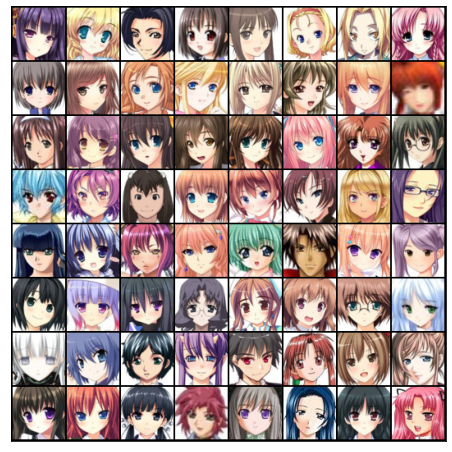

In [ ]:
show_batch(train_dl)

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device)

## Generator Network

In [ ]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

generator = to_device(generator, device)

## Visualize Fake Images

torch.Size([128, 3, 64, 64])


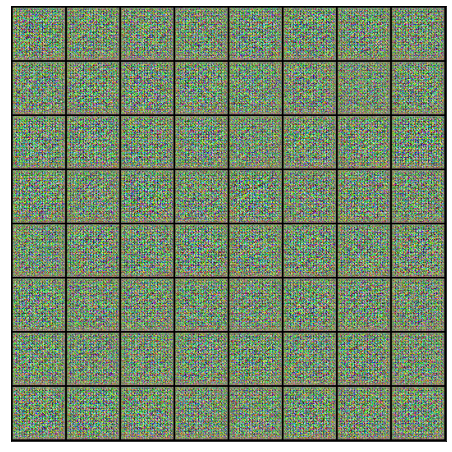

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors on cpu
xb = to_device(xb, device) # send to cuda
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images.cpu()) # get cuda to cpu

## Discriminator Training

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Generator Training

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

## Save Intermediate Images

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Saving generated-images-0000.png


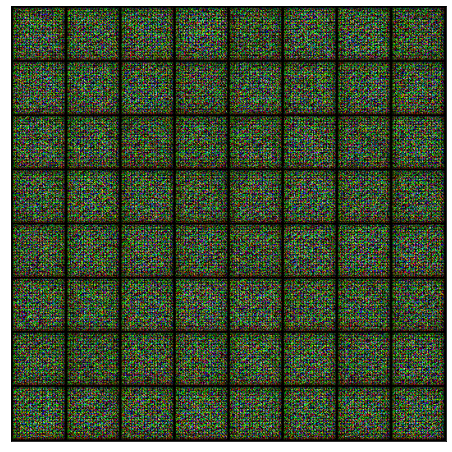

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

## Full Training Loop



In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 100

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 5.1095, loss_d: 0.2477, real_score: 0.9021, fake_score: 0.1238
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 6.0014, loss_d: 0.4796, real_score: 0.6828, fake_score: 0.0054
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 5.0786, loss_d: 0.2873, real_score: 0.8093, fake_score: 0.0243
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 4.9526, loss_d: 0.2838, real_score: 0.8556, fake_score: 0.0882
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 6.2770, loss_d: 0.3714, real_score: 0.9471, fake_score: 0.2424
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 6.0605, loss_d: 0.1534, real_score: 0.9138, fake_score: 0.0386
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 5.5267, loss_d: 0.2334, real_score: 0.9555, fake_score: 0.1534
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 5.0190, loss_d: 0.0999, real_score: 0.9577, fake_score: 0.0512
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 4.6765, loss_d: 0.1788, real_score: 0.9266, fake_score: 0.0845
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 4.7025, loss_d: 0.3398, real_score: 0.9995, fake_score: 0.2523
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 3.8633, loss_d: 0.1136, real_score: 0.9546, fake_score: 0.0586
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 7.4575, loss_d: 1.0591, real_score: 0.4645, fake_score: 0.0001
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 3.3050, loss_d: 0.2000, real_score: 0.8989, fake_score: 0.0743
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 2.4412, loss_d: 0.1332, real_score: 0.9979, fake_score: 0.1078
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 3.5597, loss_d: 0.1729, real_score: 0.8818, fake_score: 0.0352
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 3.6034, loss_d: 0.1341, real_score: 0.9730, fake_score: 0.0940
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 5.2673, loss_d: 0.1967, real_score: 0.9639, fake_score: 0.1317
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 4.6884, loss_d: 0.1653, real_score: 0.8836, fake_score: 0.0258
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 4.6271, loss_d: 0.1235, real_score: 0.9638, fake_score: 0.0776
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 4.3570, loss_d: 0.0943, real_score: 0.9705, fake_score: 0.0572
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 5.0953, loss_d: 0.1497, real_score: 0.8843, fake_score: 0.0085
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 4.8740, loss_d: 0.0962, real_score: 0.9811, fake_score: 0.0692
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 0.4756, loss_d: 2.6782, real_score: 0.1213, fake_score: 0.0002
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 8.1496, loss_d: 1.1106, real_score: 0.9981, fake_score: 0.5681
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 3.6631, loss_d: 0.1103, real_score: 0.9391, fake_score: 0.0405
Saving generated-images-0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 2.5802, loss_d: 0.4539, real_score: 0.8480, fake_score: 0.1711
Saving generated-images-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 5.9315, loss_d: 0.1907, real_score: 0.9785, fake_score: 0.1443
Saving generated-images-0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 4.6314, loss_d: 0.0768, real_score: 0.9646, fake_score: 0.0300
Saving generated-images-0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 4.9603, loss_d: 0.0363, real_score: 0.9816, fake_score: 0.0168
Saving generated-images-0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 4.3069, loss_d: 0.0758, real_score: 0.9458, fake_score: 0.0174
Saving generated-images-0030.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 5.1839, loss_d: 0.0904, real_score: 0.9331, fake_score: 0.0172
Saving generated-images-0031.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 5.3901, loss_d: 0.1800, real_score: 0.9867, fake_score: 0.1333
Saving generated-images-0032.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 3.8292, loss_d: 0.0711, real_score: 0.9509, fake_score: 0.0174
Saving generated-images-0033.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 5.1831, loss_d: 0.0941, real_score: 0.9875, fake_score: 0.0721
Saving generated-images-0034.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 4.5858, loss_d: 0.0638, real_score: 0.9574, fake_score: 0.0153
Saving generated-images-0035.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 5.0922, loss_d: 0.0493, real_score: 0.9893, fake_score: 0.0368
Saving generated-images-0036.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 2.6857, loss_d: 0.1182, real_score: 0.9133, fake_score: 0.0179
Saving generated-images-0037.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 4.2754, loss_d: 0.1011, real_score: 0.9512, fake_score: 0.0431
Saving generated-images-0038.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 5.9868, loss_d: 0.1167, real_score: 0.9861, fake_score: 0.0891
Saving generated-images-0039.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 5.7836, loss_d: 0.1884, real_score: 0.9392, fake_score: 0.0962
Saving generated-images-0040.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 4.6650, loss_d: 0.0512, real_score: 0.9851, fake_score: 0.0338
Saving generated-images-0041.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 2.3394, loss_d: 0.4815, real_score: 0.7219, fake_score: 0.0550
Saving generated-images-0042.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 3.3196, loss_d: 0.2332, real_score: 0.8410, fake_score: 0.0223
Saving generated-images-0043.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 6.3082, loss_d: 0.0581, real_score: 0.9940, fake_score: 0.0467
Saving generated-images-0044.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 4.9357, loss_d: 0.1978, real_score: 0.8883, fake_score: 0.0465
Saving generated-images-0045.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 6.0465, loss_d: 0.0550, real_score: 0.9979, fake_score: 0.0462
Saving generated-images-0046.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 6.0958, loss_d: 0.0901, real_score: 0.9846, fake_score: 0.0657
Saving generated-images-0047.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 6.3941, loss_d: 0.0451, real_score: 0.9906, fake_score: 0.0335
Saving generated-images-0048.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 5.4297, loss_d: 0.0688, real_score: 0.9546, fake_score: 0.0101
Saving generated-images-0049.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 2.4718, loss_d: 0.2912, real_score: 0.8021, fake_score: 0.0073
Saving generated-images-0050.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 4.6868, loss_d: 0.0448, real_score: 0.9660, fake_score: 0.0088
Saving generated-images-0051.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 4.5610, loss_d: 0.0424, real_score: 0.9726, fake_score: 0.0132
Saving generated-images-0052.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 5.8508, loss_d: 0.0322, real_score: 0.9918, fake_score: 0.0225
Saving generated-images-0053.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 5.5010, loss_d: 0.0285, real_score: 0.9884, fake_score: 0.0160
Saving generated-images-0054.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 5.5880, loss_d: 0.0683, real_score: 0.9630, fake_score: 0.0270
Saving generated-images-0055.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 4.1985, loss_d: 0.2711, real_score: 0.9403, fake_score: 0.1550
Saving generated-images-0056.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 4.3607, loss_d: 0.0368, real_score: 0.9740, fake_score: 0.0080
Saving generated-images-0057.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 0.0032, loss_d: 7.2182, real_score: 0.0042, fake_score: 0.0003
Saving generated-images-0058.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 4.5368, loss_d: 0.0830, real_score: 0.9448, fake_score: 0.0214
Saving generated-images-0059.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 4.7130, loss_d: 0.0502, real_score: 0.9622, fake_score: 0.0095
Saving generated-images-0060.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 5.4069, loss_d: 0.0213, real_score: 0.9859, fake_score: 0.0062
Saving generated-images-0061.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 4.7876, loss_d: 0.0278, real_score: 0.9820, fake_score: 0.0090
Saving generated-images-0062.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 4.7741, loss_d: 0.0263, real_score: 0.9951, fake_score: 0.0206
Saving generated-images-0063.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 2.6449, loss_d: 0.3277, real_score: 0.8026, fake_score: 0.0659
Saving generated-images-0064.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 5.6554, loss_d: 0.0757, real_score: 0.9829, fake_score: 0.0479
Saving generated-images-0065.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 5.7958, loss_d: 0.0242, real_score: 0.9883, fake_score: 0.0115
Saving generated-images-0066.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 5.3561, loss_d: 0.0232, real_score: 0.9833, fake_score: 0.0058
Saving generated-images-0067.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 5.2877, loss_d: 0.1253, real_score: 0.9360, fake_score: 0.0435
Saving generated-images-0068.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 5.5477, loss_d: 0.0192, real_score: 0.9926, fake_score: 0.0113
Saving generated-images-0069.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 5.1796, loss_d: 0.0273, real_score: 0.9853, fake_score: 0.0117
Saving generated-images-0070.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 7.3382, loss_d: 0.0828, real_score: 0.9985, fake_score: 0.0720
Saving generated-images-0071.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 5.0930, loss_d: 0.0271, real_score: 0.9768, fake_score: 0.0030
Saving generated-images-0072.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 4.4763, loss_d: 0.0758, real_score: 0.9717, fake_score: 0.0424
Saving generated-images-0073.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 7.9457, loss_d: 0.1552, real_score: 0.9986, fake_score: 0.1231
Saving generated-images-0074.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 6.5358, loss_d: 0.0215, real_score: 0.9870, fake_score: 0.0081
Saving generated-images-0075.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 6.2601, loss_d: 0.0382, real_score: 0.9730, fake_score: 0.0083
Saving generated-images-0076.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 6.1647, loss_d: 0.0303, real_score: 0.9859, fake_score: 0.0150
Saving generated-images-0077.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 7.0450, loss_d: 0.0173, real_score: 0.9944, fake_score: 0.0111
Saving generated-images-0078.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 7.1627, loss_d: 0.0189, real_score: 0.9958, fake_score: 0.0135
Saving generated-images-0079.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 6.8584, loss_d: 0.0153, real_score: 0.9886, fake_score: 0.0036
Saving generated-images-0080.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 5.9185, loss_d: 0.0284, real_score: 0.9849, fake_score: 0.0118
Saving generated-images-0081.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 4.8189, loss_d: 0.0639, real_score: 0.9491, fake_score: 0.0064
Saving generated-images-0082.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 5.2573, loss_d: 0.0709, real_score: 0.9554, fake_score: 0.0190
Saving generated-images-0083.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 7.4887, loss_d: 0.0197, real_score: 0.9861, fake_score: 0.0054
Saving generated-images-0084.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 6.1218, loss_d: 0.0113, real_score: 0.9933, fake_score: 0.0044
Saving generated-images-0085.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 4.2132, loss_d: 0.1542, real_score: 0.9208, fake_score: 0.0461
Saving generated-images-0086.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 3.2523, loss_d: 0.3419, real_score: 0.8630, fake_score: 0.1204
Saving generated-images-0087.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 6.4787, loss_d: 0.0142, real_score: 0.9936, fake_score: 0.0075
Saving generated-images-0088.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 6.2602, loss_d: 0.1678, real_score: 0.9842, fake_score: 0.1155
Saving generated-images-0089.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 5.9571, loss_d: 0.0359, real_score: 0.9863, fake_score: 0.0202
Saving generated-images-0090.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 5.6099, loss_d: 0.0385, real_score: 0.9689, fake_score: 0.0029
Saving generated-images-0091.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 6.8800, loss_d: 0.0139, real_score: 0.9959, fake_score: 0.0093
Saving generated-images-0092.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 4.0595, loss_d: 0.2003, real_score: 0.8895, fake_score: 0.0533
Saving generated-images-0093.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 6.1302, loss_d: 0.0210, real_score: 0.9957, fake_score: 0.0158
Saving generated-images-0094.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 3.5897, loss_d: 0.0549, real_score: 0.9519, fake_score: 0.0034
Saving generated-images-0095.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 7.9290, loss_d: 0.0138, real_score: 0.9893, fake_score: 0.0029
Saving generated-images-0096.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 4.1560, loss_d: 0.0521, real_score: 0.9698, fake_score: 0.0180
Saving generated-images-0097.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 5.0083, loss_d: 0.0172, real_score: 0.9922, fake_score: 0.0087
Saving generated-images-0098.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 7.0296, loss_d: 0.0107, real_score: 0.9938, fake_score: 0.0043
Saving generated-images-0099.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 6.8649, loss_d: 0.0470, real_score: 0.9617, fake_score: 0.0017
Saving generated-images-0100.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

## Save checkpoints.

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

## Visualize Output

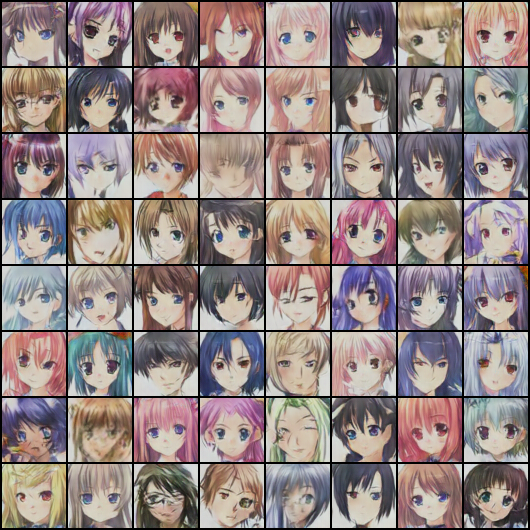

In [ ]:
Image('./generated/generated-images-0100.png')

## Visualize Losses

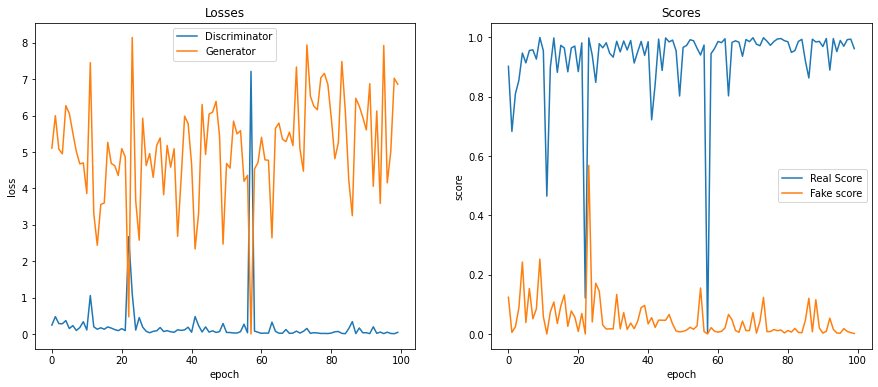

In [ ]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.grid(False)

plt.subplot(1,2,2)
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores')
plt.grid(False)

plt.show()

## Convert Saved Images to Video

In [11]:
import cv2, os

vid_fname = 'gans_training_100.avi'
sample_dir = 'generated'

im = cv2.imread(os.path.join(sample_dir, 'generated-images-0001.png'))
im.shape

(530, 530, 3)

In [12]:

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated-images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'DIVX'), 8, (im.shape[1],im.shape[0]))

In [13]:

[out.write(cv2.imread(fname)) for fname in files]
out.release()
# FileLink('gans_training.avi') # for Kaggle

## Create Zip file

In [37]:
!zip -r /content/file.zip /content/generated -q

In [ ]:
from google.colab import files
files.download("/content/file.zip")

# END